In [1]:
import numpy as np
import lightgbm as lgb
import pandas as pd
from kaggle.competitions import twosigmanews
import matplotlib.pyplot as plt
import random
from datetime import datetime, date
from sklearn import model_selection
import time
import sklearn
from sklearn.metrics import accuracy_score, mean_squared_error
from itertools import chain

In [2]:
env = twosigmanews.make_env()

(market_train_df, news_train_df) = env.get_training_data()
market_train_df = market_train_df.tail(3000000)
news_train_df = news_train_df.tail(6000000)

market_train, news_train = market_train_df.copy(), news_train_df.copy()
original = False

Loading the data... This could take a minute.
Done!


In [3]:
news_cols_agg = {
    'urgency': ['min', 'count'],
    'takeSequence': ['max'],
    'bodySize': ['min', 'max', 'mean', 'std'],
    'wordCount': ['min', 'max', 'mean', 'std'],
    'sentenceCount': ['min', 'max', 'mean', 'std'],
    'companyCount': ['min', 'max', 'mean', 'std'],
    'marketCommentary': ['min', 'max', 'mean', 'std'],
    'relevance': ['min', 'max', 'mean', 'std'],
    'sentimentNegative': ['min', 'max', 'mean', 'std'],
    'sentimentNeutral': ['min', 'max', 'mean', 'std'],
    'sentimentPositive': ['min', 'max', 'mean', 'std'],
    'sentimentWordCount': ['min', 'max', 'mean', 'std'],
    'noveltyCount12H': ['min', 'max', 'mean', 'std'],
    'noveltyCount24H': ['min', 'max', 'mean', 'std'],
    'noveltyCount3D': ['min', 'max', 'mean', 'std'],
    'noveltyCount5D': ['min', 'max', 'mean', 'std'],
    'noveltyCount7D': ['min', 'max', 'mean', 'std'],
    'volumeCounts12H': ['min', 'max', 'mean', 'std'],
    'volumeCounts24H': ['min', 'max', 'mean', 'std'],
    'volumeCounts3D': ['min', 'max', 'mean', 'std'],
    'volumeCounts5D': ['min', 'max', 'mean', 'std'],
    'volumeCounts7D': ['min', 'max', 'mean', 'std']
}

In [4]:
def join_market_news(market_train_df, news_train_df):
    news_train_df['assetCodes'] = news_train_df['assetCodes'].str.findall(f"'([\w\./]+)'")    
    
    # Expand assetCodes
    assetCodes_expanded = list(chain(*news_train_df['assetCodes']))
    assetCodes_index = news_train_df.index.repeat( news_train_df['assetCodes'].apply(len) )
    assert len(assetCodes_index) == len(assetCodes_expanded)
    df_assetCodes = pd.DataFrame({'level_0': assetCodes_index, 'assetCode': assetCodes_expanded})

    # Expand news
    news_cols = ['time', 'assetCodes'] + sorted(news_cols_agg.keys())
    news_train_df_expanded = pd.merge(df_assetCodes, news_train_df[news_cols], left_on='level_0', right_index=True, suffixes=(['','_old']))
    del news_train_df, df_assetCodes

    # Aggregate news features
    news_train_df_aggregated = news_train_df_expanded.groupby(['time', 'assetCode']).agg(news_cols_agg)
    del news_train_df_expanded
    news_train_df_aggregated = news_train_df_aggregated.apply(np.float32)

    # Flatten
    news_train_df_aggregated.columns = ['_'.join(col).strip() for col in news_train_df_aggregated.columns.values]

    # Join
    market_train_df = market_train_df.join(news_train_df_aggregated, on=['time', 'assetCode'])
    del news_train_df_aggregated
    
    return market_train_df

In [5]:
def get_x(market_train_df, news_train_df, le=None):
    # Ensure times are correct
    news_train_df['time'] = (news_train_df['time'] - np.timedelta64(22,'h')).dt.ceil('1D')
    market_train_df['time'] = market_train_df['time'].dt.floor('1D')

    # Join
    x = join_market_news(market_train_df, news_train_df)
    
    return x


In [6]:
market_train = get_x(market_train_df, news_train_df)

In [7]:
def fill_data(data):
    for i in data.columns:
        if data[i].dtype == "object":
            data[i] = data[i].fillna("other")
        elif (data[i].dtype == "int64" or data[i].dtype == "float64"):
            data[i] = data[i].fillna(data[i].mean())
        else:
            pass
    return data

market_train_df = fill_data(market_train_df)

In [8]:
def data_prep(market_train):
    market_train.time = market_train.time.dt.date
    lbl = {k: v for v, k in enumerate(market_train['assetCode'].unique())}
    market_train['assetCodeT'] = market_train['assetCode'].map(lbl)
    
    market_train = market_train.dropna(axis=0)
    
    return market_train

market_train = data_prep(market_train_df)

In [9]:
up = market_train.returnsOpenNextMktres10 >= 0
fcol = [c for c in market_train if c not in ['assetCode', 'assetCodes', 'assetCodesLen', 'assetName', 'audiences', 
                                             'firstCreated', 'headline', 'headlineTag', 'marketCommentary', 'provider', 
                                             'returnsOpenNextMktres10', 'sourceId', 'subjects', 'time', 'time_x', 'universe','sourceTimestamp']]

X = market_train[fcol].values
up = up.values
r = market_train.returnsOpenNextMktres10.values

mins = np.min(X, axis=0)
maxs = np.max(X, axis=0)
rng = maxs - mins
X = 1 - ((maxs - X) / rng)

assert X.shape[0] == up.shape[0] == r.shape[0]

In [10]:
X_train, X_test, up_train, up_test, r_train, r_test = model_selection.train_test_split(X, up, r, test_size=0.2, random_state=99)
X_train, X_val, up_train, up_val, r_train, r_val = model_selection.train_test_split(X_train, up_train, r_train, test_size=0.25, random_state=99)

train_data = lgb.Dataset(X_train, label=up_train.astype(int))
test_data = lgb.Dataset(X_test, label=up_test.astype(int))

In [11]:
# Tuning 
'''
def f(x):
    print(x)
    params = {
        'task': 'train',
        'boosting_type': 'dart',
        'objective': 'binary',
        'learning_rate': x[0],
        'num_leaves': x[1],
        'min_data_in_leaf': x[2],
        'num_iteration': 1000,
        'max_bin': x[3],
        'verbose': 1
    }
    
    gbm = lgb.train(params,
            train_data,
            num_boost_round=100,
            valid_sets=test_data,
            early_stopping_rounds=5)
            
    print(type(gbm.predict(X_test, num_iteration=gbm.best_iteration)[0]),type(up_test.astype(int)[0]))
    
    print('score: ', mean_squared_error(gbm.predict(X_test, num_iteration=gbm.best_iteration), up_test.astype(float)))
    
    return mean_squared_error(gbm.predict(X_test, num_iteration=gbm.best_iteration), up_test.astype(float))

params = [
    (0.15, 0.25), #learning_rate
    (1200, 1800), #num_leaves
    (150, 250), #min_data_in_leaf
    (150, 350) #max_bin
    ]

from skopt import gp_minimize
res = gp_minimize(
    f, params,
    acq_func="EI",
    n_calls=10) # increase n_calls for more performance

print(res.x)
'''

'\ndef f(x):\n    print(x)\n    params = {\n        \'task\': \'train\',\n        \'boosting_type\': \'dart\',\n        \'objective\': \'binary\',\n        \'learning_rate\': x[0],\n        \'num_leaves\': x[1],\n        \'min_data_in_leaf\': x[2],\n        \'num_iteration\': 1000,\n        \'max_bin\': x[3],\n        \'verbose\': 1\n    }\n    \n    gbm = lgb.train(params,\n            train_data,\n            num_boost_round=100,\n            valid_sets=test_data,\n            early_stopping_rounds=5)\n            \n    print(type(gbm.predict(X_test, num_iteration=gbm.best_iteration)[0]),type(up_test.astype(int)[0]))\n    \n    print(\'score: \', mean_squared_error(gbm.predict(X_test, num_iteration=gbm.best_iteration), up_test.astype(float)))\n    \n    return mean_squared_error(gbm.predict(X_test, num_iteration=gbm.best_iteration), up_test.astype(float))\n\nparams = [\n    (0.15, 0.25), #learning_rate\n    (1200, 1800), #num_leaves\n    (150, 250), #min_data_in_leaf\n    (150, 350) 

In [12]:
#original runs our model with the old parameters.
if original:
    vals = [0.1, 100, 1000, 255]
else:
    vals = [0.23547301150768496, 1405, 191, 265]


params = {
        'task': 'train',
        'boosting_type': 'dart',
        'objective': 'binary',
        'learning_rate': vals[0],
        'num_leaves': vals[1],
        'min_data_in_leaf': vals[2],
        'num_iteration': 1000,
        'max_bin': vals[3],
        'verbose': 1
    }
        
gbm = lgb.train(params,
        train_data,
        num_boost_round=100,
        valid_sets=test_data,
        early_stopping_rounds=10)

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's binary_logloss: 0.690161
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's binary_logloss: 0.688443
[3]	valid_0's binary_logloss: 0.687443
[4]	valid_0's binary_logloss: 0.686834
[5]	valid_0's binary_logloss: 0.686444
[6]	valid_0's binary_logloss: 0.686226
[7]	valid_0's binary_logloss: 0.686138
[8]	valid_0's binary_logloss: 0.68615
[9]	valid_0's binary_logloss: 0.686017
[10]	valid_0's binary_logloss: 0.685958
[11]	valid_0's binary_logloss: 0.685865
[12]	valid_0's binary_logloss: 0.685811
[13]	valid_0's binary_logloss: 0.685784
[14]	valid_0's binary_logloss: 0.685673
[15]	valid_0's binary_logloss: 0.685521
[16]	valid_0's binary_logloss: 0.685497
[17]	valid_0's binary_logloss: 0.685588
[18]	valid_0's binary_logloss: 0.68539
[19]	valid_0's binary_logloss: 0.685127
[20]	valid_0's binary_logloss: 0.685157
[21]	valid_0's binary_logloss: 0.68508
[22]	valid_0's binary_logloss: 0.685103
[23]	valid_0's binary_logloss: 0.685173
[24]	valid_0's binary_logloss:

In [13]:
def training_accuracy(X, y):
    preds = gbm.predict(X)*2-1
    MSE = sklearn.metrics.mean_squared_error(y, preds)
    accuracy = accuracy_score(np.array(y)>0,np.array(preds)>0)
    plt.hist(y, bins=np.linspace(-0.5,0.5,150), alpha=0.3)
    plt.hist(preds, bins=np.linspace(-0.5,0.5,150), alpha=0.3, color='darkorange')
    plt.legend(['Ground truth', 'Predicted'])
    plt.xlabel("Confidence")
    plt.ylabel("Count")
    plt.title("predicted confidence")
    plt.show()
    return MSE, accuracy

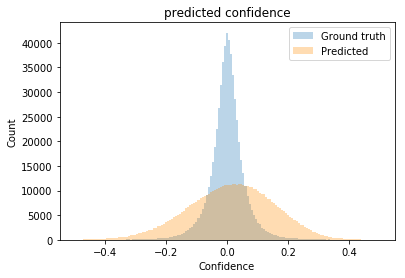

Test MSE = 0.022988625703350318, Test Accuracy = 0.55283


In [14]:
mse, accuracy = training_accuracy(X_test, r_test)
print ("Test MSE = " + str(mse) + ", Test Accuracy = " + str(accuracy))

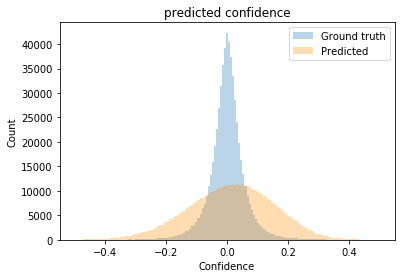

Val MSE = 0.08153439520464814, Val Accuracy = 0.5522583333333333


In [15]:
mse, accuracy = training_accuracy(X_val, r_val)
print ("Val MSE = " + str(mse) + ", Val Accuracy = " + str(accuracy))

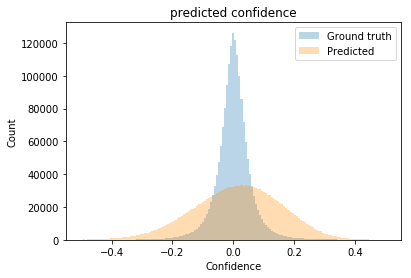

Train MSE = 0.020813479081701242, Train Accuracy = 0.6369538888888889


In [16]:
mse, accuracy = training_accuracy(X_train, r_train)
print ("Train MSE = " + str(mse) + ", Train Accuracy = " + str(accuracy))

In [17]:
#Competition
days = env.get_prediction_days()
for (market_obs_df, news_obs_df, predictions_template_df) in days:
    market_obs_df = data_prep(market_obs_df)
    market_obs_df = market_obs_df[market_obs_df.assetCode.isin(predictions_template_df.assetCode)]
    X_live = market_obs_df[fcol].values
    X_live = 1 - ((maxs - X_live) / rng)
    
    t = time.time()
    lp = (gbm.predict(X_live))

    confidence = lp
    confidence = (confidence-confidence.min())/(confidence.max()-confidence.min())
    confidence = confidence * 2 - 1
    preds = pd.DataFrame({'assetCode':market_obs_df['assetCode'],'confidence':confidence})
    predictions_template_df = predictions_template_df.merge(preds,how='left').drop('confidenceValue',axis=1).fillna(0).rename(columns={'confidence':'confidenceValue'})
    env.predict(predictions_template_df)
    
env.write_submission_file()
sub  = pd.read_csv("submission.csv")

Your submission file has been saved. Once you `Commit` your Kernel and it finishes running, you can submit the file to the competition from the Kernel Viewer `Output` tab.
